# Statistiques par groupe et association de plusieurs jeux de données

avec Pandas

Lino Galiana  
2024-06-17

Pour essayer les exemples présents dans ce tutoriel :

# 1. Introduction

Le [chapitre d’introduction à `Pandas`](../../content/manipulation/02_pandas_intro.qmd) a permis de présenter le principe de données organisées sous une forme de *DataFrame* et la praticité de l’écosystème `Pandas` pour effectuer des opérations simples sur un jeu de données.

Il est rare de travailler exclusivement sur une source brute. Un jeu de données prend généralement de la valeur lorsqu’il est comparé à d’autres sources. Pour des chercheurs, cela permettra de contextualiser l’information présente dans une source en la comparant ou en l’associant à d’autres sources. Pour des *data scientists* dans le secteur privé, il s’agira souvent d’associer des informations sur une même personne dans plusieurs bases clientes ou comparer les clients entre eux.

L’un des apports des outils modernes de *data science*, notamment `Pandas` est la simplicité par laquelle ils permettent de restructurer des sources pour travailler sur plusieurs données sur un projet.
Ce chapitre consolide ainsi les principes vus précédemment en raffinant les traitements faits sur les données. Il va explorer principalement deux types d’opérations:

-   les statistiques descriptives par groupe ;
-   l’association de données par des caractéristiques communes.

Effectuer ce travail de manière simple, fiable et efficace est indispensable pour les *data scientists* tant cette tâche est courante. Heureusement `Pandas` permet de faire cela très bien avec des données structurées. Nous verrons dans les prochains chapitres, mais aussi dans l’ensemble de la [partie sur le traitement des données textuelles](../../content/nlp/index.qmd), comment faire avec des données moins structurées.

Grâce à ce travail, nous allons approfondir notre compréhension d’un phénomène réel par le biais de statistiques descriptives fines. Cela est une étape indispensable avant de basculer vers la [statistique inférentielle](https://fr.wikipedia.org/wiki/Inf%C3%A9rence_statistique#:~:text=L'inf%C3%A9rence%20statistique%20est%20l,%3A%20la%20probabilit%C3%A9%20d'erreur.), l’approche qui consiste à formaliser et généraliser des liens de corrélation ou de causalité entre des caractéristiques observées et un phénomène.

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Compétences à l'issue de ce chapitre</h3>

-   Récupérer un jeu de données officiel de l’Insee ;
-   Construire des statistiques descriptives par groupe et jongler entre les niveaux des données ;
-   Associer des données (*reshape*, *merge*) pour leur donner plus de valeur ;
-   Faire un beau tableau pour communiquer des statistiques descriptives.

</div>

## 1.1 Environnement

Le chapitre précédent utilisait quasi exclusivement la librairie `Pandas`. Nous allons dans ce chapitre utiliser d’autres *packages* en complément de celui-ci.

Comme expliqué ci-dessous, nous allons utiliser une librairie nommée `pynsee` pour récupérer les données de l’Insee utiles à enrichir notre jeu de données de l’Ademe. Cette librairie n’est pas installée par défaut dans `Python`. Avant de pouvoir l’utiliser,
il est nécessaire de l’installer, comme la librairie `great_tables` que nous verrons à la fin de ce chapitre:

In [1]:
!pip install xlrd
!pip install pynsee
!pip install great_tables

L’instruction `!pip install <pkg>` est une manière de faire comprendre à `Jupyter`, le moteur d’exécution derrière les *notebooks* que la commande qui suit (`pip install` ce `<pkg>`)
est une commande système, à exécuter hors de `Python` (dans le terminal par exemple pour un système `Linux`).

Les premiers *packages* indispensables pour démarrer ce chapitre sont les suivants:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynsee
import pynsee.download


Pour obtenir des résultats reproductibles, on peut fixer la racine du générateur
pseudo-aléatoire.

In [3]:
np.random.seed(123)


## 1.2 Données utilisées

Ce tutoriel continue l’exploration du jeu de données du chapitre précédent:

-   Les émissions de gaz à effet de serre estimées au niveau communal par l’ADEME. Le jeu de données est
    disponible sur [data.gouv](https://www.data.gouv.fr/fr/datasets/inventaire-de-gaz-a-effet-de-serre-territorialise/#_)
    et requêtable directement dans `Python` avec
    [cet url](https://koumoul.com/s/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert) ;

Les problématiques d’enrichissement de données (association d’une source à une autre à partir de caractéristiques communes) seront présentées à partir de deux sources produites par l’Insee:

-   Le
    [code officiel géographique](https://www.insee.fr/fr/statistiques/fichier/6800675/v_commune_2023.csv),
    un référentiel
    produit par l’Insee utilisé pour identifier les communes à partir d’un code unique, contrairement au code postal ;
-   Les données [*Filosofi*](https://www.insee.fr/fr/metadonnees/source/serie/s1172), une source sur les revenus des Français à une échelle spatiale fine construite par l’Insee à partir des déclarations fiscales et d’informations sur les prestations sociales. En l’occurrence, nous allons utiliser les niveaux de revenu et les populations[1] au niveau communal afin de les mettre en regard de nos données d’émissions.

Pour faciliter l’import de données Insee, il est recommandé d’utiliser le *package*
[`pynsee`](https://pynsee.readthedocs.io/en/latest/) qui simplifie l’accès aux principaux jeux de données
de l’Insee disponibles sur le site web [insee.fr](https://www.insee.fr/fr/accueil)
ou via des API.

[1] Idéalement il serait plus cohérent, pour les données démographiques, d’utiliser les [populations légales](https://www.insee.fr/fr/information/2008354), issues du recensement. Néanmoins cette base n’est pas encore intégrée nativement dans la librairie `pynsee` que nous allons utiliser dans ce chapitre. Un exercice d’ouverture est proposé pour construire des agrégats de population à partir des jeux de données individuels anonymisés du recensement (les [fichiers détails](https://www.insee.fr/fr/information/2383306)).

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

Le *package* `pynsee` comporte deux principaux points d’entrée :

-   Les API de l’Insee, ce qui sera illustré dans le chapitre consacré.
-   Quelques jeux de données directement issus du site web de
    l’Insee ([insee.fr](https://www.insee.fr/fr/accueil))

Dans ce chapitre, nous allons exclusivement utiliser cette deuxième
approche. Cela se fera par le module `pynsee.download`.

La liste des données disponibles depuis ce *package* est [ici](https://inseefrlab.github.io/DoReMIFaSol/articles/donnees_dispo.html).
La fonction `download_file` attend un identifiant unique
pour savoir quelle base de données aller chercher et
restructurer depuis le
site [insee.fr](https://www.insee.fr/fr/accueil).

<details>

<summary>

Connaître la liste des bases disponibles

</summary>

Pour connaître la liste des bases disponibles, vous
pouvez utiliser la fonction `meta = pynsee.get_file_list()`
après avoir fait `import pynsee`.
Celle-ci renvoie un `DataFrame` dans lequel on peut
rechercher, par exemple grâce à une recherche
de mots-clefs :

``` python
import pynsee

meta = pynsee.get_file_list()
meta.loc[meta["label"].str.contains(r"Filosofi.*2016")]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|     | id                   | name            | label                                             | collection | link                                              | type | zip  | big_zip | data_file                 | tab    | ... | label_col | date_ref   | meta_file | separator | type_col | long_col | val_col | encoding | last_row | missing_value |
|-----|----------------------|-----------------|---------------------------------------------------|------------|---------------------------------------------------|------|------|---------|---------------------------|--------|-----|-----------|------------|-----------|-----------|----------|----------|---------|----------|----------|---------------|
| 79  | FILOSOFI_COM_2016    | FILOSOFI_COM    | Données Filosofi niveau communal – 2016           | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | COM    | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 80  | FILOSOFI_EPCI_2016   | FILOSOFI_EPCI   | Données Filosofi niveau EPCI – 2016               | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | EPCI   | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 81  | FILOSOFI_ARR_2016    | FILOSOFI_ARR    | Données Filosofi niveau arondissement – 2016      | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | ARR    | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 82  | FILOSOFI_DEP_2016    | FILOSOFI_DEP    | Données Filosofi niveau départemental – 2016      | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | DEP    | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 83  | FILOSOFI_REG_2016    | FILOSOFI_REG    | Données Filosofi niveau régional – 2016           | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | REG    | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 84  | FILOSOFI_METRO_2016  | FILOSOFI_METRO  | Données Filosofi niveau France métropolitaine ... | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | METRO  | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 85  | FILOSOFI_AU2010_2016 | FILOSOFI_AU2010 | Données Filosofi niveau aire urbaine – 2016       | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | AU2010 | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 86  | FILOSOFI_UU2010_2016 | FILOSOFI_UU2010 | Données Filosofi niveau unité urbaine – 2016      | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | UU2010 | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 87  | FILOSOFI_ZE2010_2016 | FILOSOFI_ZE2010 | Données Filosofi niveau zone d’emploi – 2016      | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | ZE2010 | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |

<p>9 rows × 24 columns</p>
</div>

Ici, `meta['label'].str.contains(r"Filosofi.*2016")` signifie:
“*`pandas` trouve moi tous les labels où sont contenus les termes Filosofi et 2016.*”
(`.*` signifiant “*peu m’importe le nombre de mots ou caractères entre*”)

</details>

</div>

# 2. Récupération des jeux de données

## 2.1 Données d’émission de l’Ademe

Comme expliqué au chapitre précédent, ces données peuvent être importées très simplement avec `Pandas`

In [5]:
import pandas as pd

url = "https://koumoul.com/s/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert"
emissions = pd.read_csv(url)
emissions.head(2)


Nous allons d’ores et déjà conserver le nom des secteurs émetteurs présents dans la base de données pour simplifier des utilisations ultérieures:

In [6]:
secteurs = emissions.select_dtypes(include="number").columns


Les exploitations ultérieures de ces données utiliseront la dimension départementale dont nous avons montré la construction au chapitre précédent:

In [7]:
emissions["dep"] = emissions["INSEE commune"].str[:2]


## 2.2 Données *Filosofi*

On va utiliser les données Filosofi (données de revenus) au niveau communal de 2016.
Ce n’est pas la même année que les données d’émission de CO2, ce n’est donc pas parfaitement rigoureux,
mais cela permettra tout de même d’illustrer
les principales fonctionnalités de `Pandas`

Le point d’entrée principal de la fonction `pynsee` est la fonction `download_file`.

Le code pour télécharger les données est le suivant :

In [8]:
from pynsee.download import download_file

filosofi = download_file("FILOSOFI_COM_2016")


Le *DataFrame* en question a l’aspect suivant :

In [9]:
filosofi.sample(3)


3 rows × 29 columns

`Pandas` a géré automatiquement les types de variables. Il le fait relativement bien, mais une vérification est toujours utile pour les variables qui ont un statut spécifique.

Pour les variables qui ne sont pas en type `float` alors qu’elles devraient l’être, on modifie leur type.

In [10]:
filosofi = filosofi.astype({c: "float" for c in filosofi.columns[2:]})


Un simple coup d’oeil sur les données
donne une idée assez précise de la manière dont les données sont organisées.
On remarque que certaines variables de `filosofi` semblent avoir beaucoup de valeurs manquantes (secret statistique)
alors que d’autres semblent complètes.
Si on désire exploiter `filosofi`, il faut faire attention à la variable choisie.

Notre objectif à terme va être de relier l’information contenue entre ces
deux jeux de données. En effet, sinon, nous risquons d’être frustré : nous allons
vouloir en savoir plus sur les émissions de gaz carbonique mais seront très
limités dans les possibilités d’analyse sans ajout d’une information annexe
issue de `filosofi`.

# 3. Statistiques descriptives par groupe

## 3.1 Principe

Nous avons vu, lors du chapitre précédent, comment obtenir
une statistique agrégée simplement grâce à `Pandas`.
Il est néanmoins commun d’avoir des données avec des strates
intermédiaires d’analyse pertinentes: des variables géographiques, l’appartenance à des groupes socio-démographiques liés à des caractéristiques renseignées, des indicatrices de période temporelle, etc.
Pour mieux comprendre la structure de ses données, les *data scientists* sont donc souvent amenés à construire des statistiques descriptives sur des sous-groupes présents dans les données. Pour reprendre l’exemple sur les émissions, nous avions précédemment construit des statistiques d’émissions au niveau national. Mais qu’en est-il du profil d’émission des différents départements ? Pour répondre à cette question, il sera utile d’agréger nos données au niveau départemental. Ceci nous donnera une information différente du jeu de données initial (niveau communal) et du niveau le plus agrégé (niveau national).

En `SQL`, il est très simple de découper des données pour
effectuer des opérations sur des blocs cohérents et recollecter des résultats
dans la dimension appropriée.
La logique sous-jacente est celle du *split-apply-combine* qui est repris
par les langages de manipulation de données, auxquels `pandas`
[ne fait pas exception](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html).

L’image suivante, issue de
[ce site](https://unlhcc.github.io/r-novice-gapminder/16-plyr/),
représente bien la manière dont fonctionne l’approche
`split`-`apply`-`combine`:

<figure>
<img src="https://unlhcc.github.io/r-novice-gapminder/fig/12-plyr-fig1.png" alt="Split-apply-combine (Source: unlhcc.github.io)" />
<figcaption aria-hidden="true">Split-apply-combine (Source: <a href="https://unlhcc.github.io/r-novice-gapminder/16-plyr/">unlhcc.github.io</a>)</figcaption>
</figure>

En `Pandas`, on utilise `groupby` pour découper les données selon un ou
plusieurs axes (ce [tutoriel](https://realpython.com/pandas-groupby/) sur le sujet
est particulièrement utile).
L’ensemble des opérations d’agrégation (comptage, moyennes, etc.) que nous avions vues précédemment peut être mise en oeuvre par groupe.

Techniquement, cette opération consiste à créer une association
entre des labels (valeurs des variables de groupe) et des
observations. Utiliser la méthode `groupby` ne déclenche pas d’opérations avant la mise en oeuvre d’une statistique, cela créé seulement une relation formelle entre des observations et des regroupemens qui seront utilisés *a posteriori*:

In [11]:
filosofi["dep"] = filosofi["CODGEO"].str[:2]
filosofi.groupby("dep").__class__


pandas.core.groupby.generic.DataFrameGroupBy

Tant qu’on n’appelle pas une action sur un `DataFrame` par groupe, du type
`head` ou `display`, `pandas` n’effectue aucune opération. On parle de
*lazy evaluation*. Par exemple, le résultat de `df.groupby('dep')` est
une transformation qui n’est pas encore évaluée :

In [12]:
filosofi.groupby("dep")


## 3.2 Illustration 1: dénombrement par groupe

Pour illustrer l’application de ce principe à un comptage, on peut dénombrer le nombre de communes par département en 2023 (chaque année cette statistique change du fait des fusions de communes). Pour cela, il suffit de prendre le référentiel des communes françaises issu du code officiel géographique (COG) et dénombrer par département grâce à `count`:

In [13]:
import pandas as pd

url_cog_2023 = "https://www.insee.fr/fr/statistiques/fichier/6800675/v_commune_2023.csv"
cog_2023 = pd.read_csv(url_cog_2023)


Grâce à ce jeu de données, sans avoir recours aux statistiques par groupe, on peut déjà savoir combien on a, respectivement, de communes, départements et régions en France:

In [14]:
communes = cog_2023.loc[cog_2023["TYPECOM"] == "COM"]
communes.loc[:, ["COM", "DEP", "REG"]].nunique()

COM    34945
DEP      101
REG       18
dtype: int64

Maintenant, intéressons nous aux départements ayant le plus de communes. Il s’agit de la même fonction de dénombrement où on joue, cette fois, sur le groupe à partir duquel est calculé la statistique.

Calculer cette statistique se fait de manière assez transparente lorsqu’on connaît le principe d’un calcul de statistiques avec `Pandas`:

In [15]:
communes = cog_2023.loc[cog_2023["TYPECOM"] == "COM"]
communes.groupby("DEP").agg({"COM": "nunique"})

101 rows × 1 columns

En SQL, on utiliserait la requête suivante:

``` sql
SELECT dep, COUNT DISTINCT "COM" AS COM 
FROM communes
GROUP BY dep 
WHERE TYPECOM == 'COM';
```

La sortie est une `Serie` indexée. Ce n’est pas très pratique comme nous avons pu l’évoquer au cours du chapitre précédent. Il est plus pratique de transformer cet objet en `DataFrame` avec `reset_index`. Enfin, avec `sort_values`, on obtient la statistique désirée:

In [16]:
(
    communes.groupby("DEP")
    .agg({"COM": "nunique"})
    .reset_index()
    .sort_values("COM", ascending=False)
)


101 rows × 2 columns

## 3.3 Illustration 2: agrégats par groupe

Pour illustrer les agrégats par groupe nous pouvons prendre le jeu de données de l’Insee `filosofi` et compter la population grâce à la variable `NBPERSMENFISC16`.

Pour calculer le total au niveau France entière nous pouvons faire de deux manières :

In [17]:
filosofi["NBPERSMENFISC16"].sum() * 1e-6


66.9322415

In [18]:
filosofi.agg({"NBPERSMENFISC16": "sum"}).div(1e6)


NBPERSMENFISC16    66.932242
dtype: float64

où les résultats sont reportés en millions de personnes. La logique est identique lorsqu’on fait des statistiques par groupe, il s’agit seulement de remplacer `filosofi` par `filosofi.groupby('dep')` pour créer une version partitionnée par département de notre jeu de données:

In [19]:
filosofi.groupby("dep")["NBPERSMENFISC16"].sum()

dep
01     613088.0
02     514249.0
03     329435.0
04     156537.5
05     133992.5
        ...    
92    1583682.0
93    1586664.5
94    1345977.0
95    1226059.0
97    1191947.0
Name: NBPERSMENFISC16, Length: 97, dtype: float64

In [20]:
filosofi.groupby("dep").agg({"NBPERSMENFISC16": "sum"})


97 rows × 1 columns

La seconde approche est plus pratique car elle donne directement un `DataFrame` `Pandas` et non une série indexée sans nom. A partir de celle-ci, quelques manipulations basiques peuvent suffire pour avoir un tableau diffusables sur la démographie départementale. Néanmoins, celui-ci, serait quelques peu brut de décoffrage car nous ne possédons à l’heure actuelle que les numéros de département. Pour avoir le nom de départements, il faudrait utiliser une deuxième base de données et croiser les informations communes entre elles (en l’occurrence le numéro du département). C’est l’objet de la prochaine partie.

## 3.4 Exercice d’application

Cet exercice d’application s’appuie sur le jeu de données de l’Ademe nommé `emissions` précédemment.

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 1 : agrégations par groupe</h3>

1.  Calculer les émissions totales du secteur “Résidentiel” par département et rapporter la valeur au département le plus polluant dans le domaine. En tirer des intutitions sur la réalité que cette statistique reflète.

2.  Calculer, pour chaque département, les émissions totales de chaque secteur. Pour chaque département, calculer la proportion des émissions totales venant de chaque secteur.

<details>

<summary>

Indice pour cette question

</summary>

-   *“Grouper par”* = `groupby`
-   *“émissions totales”* = `agg({*** : "sum"})`

</details>

</div>

A la question 1, le résultat obtenu devrait être le suivant:

Ce classement reflète peut-être plus la démographie que le processus qu’on désire mesurer. Sans l’ajout d’une information annexe sur la population de chaque département pour contrôler ce facteur, on peut difficilement savoir s’il y a une différence structurelle de comportement entre les habitants du Nord (département 59) et ceux de la Moselle (département 57).

A l’issue de la question 2, prenons la part des émissions de l’agriculture et du secteur tertiaire dans les émissions départementales:

5 rows × 21 columns

5 rows × 21 columns

Ces résultats sont assez logiques ; les départements ruraux ont une part plus importante de leur émission issue de l’agriculture, les départements urbains ont plus d’émissions issues du secteur tertiaire, ce qui est lié à la densité plus importante de ces espaces.

Grâce à ces statistiques on progresse dans la connaissance de notre jeu de données et donc de la nature des émissions de C02 en France.
Les statistiques descriptives par groupe nous permettent de mieux saisir l’hétérogénéité spatiale de notre phénomène.

Cependant, on reste limité dans notre capacité à interpréter les statistiques obtenues sans recourir à l’utilisation d’information annexe. Pour donner du sens et de la valeur à une statistique, il faut généralement associer celle-ci à de la connaissance annexe sous peine qu’elle soit désincarnée.

Dans la suite de ce chapitre, nous envisagerons une première voie qui est le croisement avec des données complémentaires. On appelle ceci un enrichissement de données. Ces données peuvent être des observations à un niveau identique à celui de la source d’origine. Par exemple, l’un des croisements les plus communs est d’associer une base client à une base d’achats afin de mettre en regard un comportement d’achat avec des caractéristiques pouvant expliquer celui-ci. Les associations de données peuvent aussi se faire à des niveaux conceptuels différents, en général à un niveau plus agrégé pour contextualiser la donnée plus fine et comparer une observation à des mesures dans un groupe similaire. Par exemple, on peut associer des temps et des modes de transports individuels à ceux d’une même classe d’âge ou de personnes résidant dans la même commune pour pouvoir comparer la différence entre certains individus et un groupe sociodémographique similaire.

# 4. Restructurer les données

## 4.1 Principe

Quand on a plusieurs informations pour un même individu ou groupe, on
retrouve généralement deux types de structure de données :

-   format **wide** : les données comportent des observations répétées, pour un même individu (ou groupe), dans des colonnes différentes
-   format **long** : les données comportent des observations répétées, pour un même individu, dans des lignes différentes avec une colonne permettant de distinguer les niveaux d’observations

Un exemple de la distinction entre les deux peut être pris à l’ouvrage de référence d’Hadley Wickham, [*R for Data Science*](https://r4ds.hadley.nz/):

<figure>
<img src="https://d33wubrfki0l68.cloudfront.net/3aea19108d39606bbe49981acda07696c0c7fcd8/2de65/images/tidy-9.png" alt="Données long et wide (Source: R for Data Science)" />
<figcaption aria-hidden="true">Données <em>long</em> et <em>wide</em> (Source: <a href="https://r4ds.hadley.nz/"><em>R for Data Science</em></a>)</figcaption>
</figure>

L’aide mémoire suivante aidera à se rappeler les fonctions à appliquer si besoin :

![](https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/reshape.png)

Le fait de passer d’un format *wide* au format *long* (ou vice-versa)
peut être extrêmement pratique car certaines fonctions sont plus adéquates sur une forme de données ou sur l’autre.

En règle générale, avec `Python` comme avec `R`, les **formats *long* sont souvent préférables**.
Les formats *wide* sont plutôt pensés pour des tableurs comme `Excel` ou on dispose d’un nombre réduit
de lignes à partir duquel faire des tableaux croisés dynamiques.

## 4.2 Exercice d’application

Les données de l’ADEME, et celles de l’Insee également, sont au format
*wide*.
Le prochain exercice illustre l’intérêt de faire la conversion *long* $\to$ *wide*
avant de faire un graphique avec la méthode `plot` vue au chapitre précédent

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 2: Restructurer les données : wide to long</h3>

1.  Créer une copie des données de l’`ADEME` en faisant `df_wide = emissions_wide.copy()`

2.  Restructurer les données au format *long* pour avoir des données d’émissions par secteur en gardant comme niveau d’analyse la commune (attention aux autres variables identifiantes).

3.  Faire la somme par secteur et représenter graphiquement

4.  Garder, pour chaque département, le secteur le plus polluant

</div>

# 5. Joindre des données

## 5.1 Principe

Nous allons ici nous focaliser sur le cas le plus favorable qui est la situation
où une information permet d’apparier de manière exacte deux bases de données[1].
C’est un besoin quotidien des *data scientists* d’associer des informations présentes dans plusieurs fichiers. Par exemple, dans des bases de données d’entreprises, les informations clients (adresse, âge, etc.) seront dans un fichier, les ventes dans un autre et les caractéristiques des produits dans un troisième fichier. Afin d’avoir une base complète mettant en regard toutes ces informations, il sera dès lors nécessaire de joindre ces trois fichiers sur la base d’informations communes.

Cette pratique découle du fait que de nombreux systèmes d’information prennent la forme d’un schéma en étoile:

<figure>
<img src="https://www.databricks.com/wp-content/uploads/2022/04/star-schema-erd.png" alt="Illustration du schéma en étoile (Source: Databricks)" />
<figcaption aria-hidden="true">Illustration du schéma en étoile (Source: <a href="https://www.databricks.com/wp-content/uploads/2022/04/star-schema-erd.png">Databricks</a>)</figcaption>
</figure>

Cette structuration de l’information est très liée au modèle des tables relationnelles des années 1980. Aujourd’hui, il existe des modèles de données plus flexibles où l’information est empilée dans un *data lake* sans structure *a priori*. Néanmoins ce modèle du schéma en étoile conserve une pertinence parce qu’il permet de partager l’information qu’à ceux qui en ont besoin laissant le soin à ceux qui ont besoin de lier des données entre elles de le faire.

Puisque la logique du schéma en étoile vient historiquement des bases relationnelles, il est naturel qu’il s’agisse d’une approche intrinsèquement liée à la philosophie du SQL, jusque dans le vocabulaire. On parle souvent de jointure de données, un héritage du terme `JOIN` de SQL, et la manière de décrire les jointures (*left join*, *right join*…) est directement issue des instructions SQL associées.

On parle généralement de base de gauche et de droite pour illustrer les jointures:

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/join_initial.png)

## 5.2 Mise en oeuvre avec `Pandas`

En `Pandas`, la méthode la plus pratique pour associer des jeux de données à partir de caractéristiques communes est `merge`. Ses principaux arguments permettent de contrôler le comportement de jointure. Nous allons les explorer de manière visuelle.

En l’occurrence, pour notre problématique de construction de statistiques
sur les émissions de gaz carbonique, la base de gauche sera le *DataFrame* `emission` et la base de droite le *DataFrame* `filosofi`:

[1] Autrement, on rentre dans le monde des appariements flous ou des appariements probabilistes. Les appariements flous sont des situations où on ne dispose plus d’un identifiant exact pour associer deux bases mais d’une information partiellement bruitée entre deux sources pour faire cette mise en relation. Par exemple, dans une base de données produit on aura `Coca Cola 33CL` et dans une autre `Coca Cola canette` mais sous ces deux noms sont cachés le même produit. Le chapitre d’[ouverture aux enjeux de recherche textuelle avec `ElasticSearch`](../../content/modern-ds/elastic.qmd) est consacré à cette problématique. Les appariements probabilistes sont un autre type d’approche. Dans ceux-ci, on associe des observations dans deux bases non pas sur la base d’un identifiant mais sur la distance entre un ensemble de caractéristiques dans les deux bases. Cette technique est très utilisée dans les statistiques médicales ou dans l’évaluation de politiques publiques sur la base du [*propensity score matching*](https://en.wikipedia.org/wiki/Propensity_score_matching).

In [29]:
emissions.head(2)


In [30]:
filosofi.head(2)


2 rows × 30 columns

On parle de clé(s) de jointure pour nommer la ou les variable(s) nécessaire(s) à la fusion de données. Ce sont les variables communes aux deux jeux de données. Il n’est pas nécessaire qu’elles aient le même nom en revanche elles doivent partager des valeurs communes autrement l’intersection entre ces deux bases est l’ensemble vide.

On peut jouer sur deux dimensions dans la jointure (ceci sera plus clair ensuite avec les exemples graphiques).

-   Il existe principalement trois types de fusions: *left join* et *right join* ou un combo des deux selon le type de pivot qu’on désire mettre en oeuvre.
-   Ensuite, il existe deux manières de fusionner les valeurs une fois qu’on a choisi un pivot: *inner* ou *outer join*. Dans le premier cas, on ne conserve que les observations où les clés de jointures sont présentes dans les deux bases, dans le second on conserve toutes les observations de la clé de jointure des variables pivot quitte à avoir des valeurs manquantes si la deuxième base de données n’a pas de telles observations.

Dans les exemples ci-dessous, nous allons utiliser les codes communes et les départements comme variables de jointure. En soi, l’usage du département n’est pas nécessaire puisqu’il se déduit directement du code commune mais cela permet d’illustrer le principe des jointures sur plusieurs variables. A noter que le nom de la commune est volontairement mis de côté pour effectuer des jointures alors que c’est une information commune aux deux bases. Cependant, comme il s’agit d’un champ textuel, dont le formattage peut suivre une norme différente dans les deux bases, ce n’est pas une information fiable pour faire une jointure exacte.

Pour illustrer le principe du pivot à gauche ou à droite, on va créer deux variables identificatrices de la ligne de nos jeux de données de gauche et de droite. Cela nous permettra de trouver facilement les lignes présentes dans un jeu de données mais pas dans l’autre.

In [31]:
emissions = emissions.reset_index(names=["id_left"])
filosofi = filosofi.reset_index(names=["id_right"])


### 5.2.1 *Left join*

Commençons avec la jointure à gauche. Comme son nom l’indique, on va prendre la variable de gauche en pivot:

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/left_join.png)

In [32]:
left_merged = emissions.merge(
    filosofi, left_on=["INSEE commune", "dep"], right_on=["CODGEO", "dep"], how="left"
)
left_merged.head(3)


3 rows × 44 columns

Il est recommandé de toujours expliciter les clés de jointures par le biais des arguments `left_on`, `right_on` ou `on` si les noms de variables sont communs dans les deux bases.
Si on a des noms de variables communes entre les bases mais qu’elles ne sont pas définies comme clés de jointures, celles-ci ne seront pas utilisées pour joindre mais seront conservées avec un suffixe qui par défaut est `_x` et `_y` (paramétrable par le biais de l’argument `suffixes`).

La syntaxe `Pandas` étant directement inspirée de SQL, on a une traduction assez transparente de l’instruction ci-dessus en SQL:

``` sql
SELECT *
FROM emissions
LEFT JOIN filosofi
  ON emissions.`INSEE commune` = filosofi.CODGEO
  AND emissions.dep = filosofi.dep;
```

En faisant une jointure à gauche, on doit en principe avoir autant de lignes que la base de données à gauche:

In [33]:
left_merged.shape[0] == emissions.shape[0]


True

Autrement, cela est signe qu’il y a une clé dupliquée à droite. Grâce à notre variable `id_right`, on peut savoir les codes communes à droite qui n’existent pas à gauche:

In [34]:
left_merged.loc[left_merged["id_right"].isna()].tail(3)


3 rows × 44 columns

Cela vient du fait que nous utilisons des données qui ne sont pas de la même année de référence du code officiel géographique (2016 vs 2018). Pendant cet intervalle, il y a eu des changements de géographie, notamment des fusions de communes. Par exemple, la commune de Courcouronnes qu’on a vu ci-dessus peut être retrouvée regroupée avec Evry dans le jeu de données filosofi (base de droite):

In [35]:
filosofi.loc[filosofi["LIBGEO"].str.lower().str.contains("courcouronnes")]


1 rows × 31 columns

Dans un exercice de construction de statistiques publiques, on ne pourrait donc se permettre cette disjonction des années.

### 5.2.2 \_Right join\_\_

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/right_join.png)

Le principe est le même mais cette fois c’est la base de droite qui est prise sous forme de pivot:

In [36]:
right_merged = emissions.merge(
    filosofi, left_on=["INSEE commune", "dep"], right_on=["CODGEO", "dep"], how="right"
)
right_merged.head(3)


3 rows × 44 columns

L’instruction équivalente en SQL serait

``` sql
SELECT *
FROM filosofi
RIGHT JOIN emissions
  ON filosofi.CODGEO = emissions.`INSEE commune`
  AND filosofi.dep = emissions.dep;
```

On peut, comme précédemment, vérifier la cohérence des dimensions:

In [37]:
right_merged.shape[0] == filosofi.shape[0]


True

Pour vérifier le nombre de lignes des données Filosofi que nous n’avons pas dans notre jeu d’émissions de gaz carbonique, on peut faire

In [38]:
right_merged["id_left"].isna().sum()


61

C’est un nombre faible. Quelles sont ces observations ?

In [39]:
right_merged.loc[
    right_merged["id_left"].isna(),
    filosofi.columns.tolist() + emissions.columns.tolist(),
]


61 rows × 45 columns

Il est suprenant de voir que Paris, Lyon et Marseille sont présents
dans la base des statistiques communales mais pas dans celles des émissions.
Pour comprendre pourquoi, recherchons dans nos données d’émissions les observations liées à Marseille:

In [40]:
emissions.loc[emissions["Commune"].str.lower().str.contains("MARSEILLE")]


Cela vient du fait que le jeu de données des émissions de l’Ademe propose de l’information sur les arrondissements dans les trois plus grandes villes
là où le jeu de données de l’Insee ne fait pas cette décomposition.

### 5.2.3 *Inner join*

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/inner.png)

Il s’agit du jeu de données où les clés sont retrouvées à l’intersection des deux tables.

In [41]:
inner_merged = emissions.merge(
    filosofi, left_on=["INSEE commune", "dep"], right_on=["CODGEO", "dep"], how="inner"
)
inner_merged.head(3)


3 rows × 44 columns

En SQL, cela donne

``` sql
SELECT *
FROM emissions
INNER JOIN filosofi
  ON emissions.`INSEE commune` = filosofi.CODGEO
  AND emissions.dep = filosofi.dep;
```

Le nombre de lignes dans notre jeu de données peut être comparé au jeu de droite et de gauche:

In [42]:
inner_merged.shape[0] == (left_merged.shape[0] - left_merged["id_right"].isna().sum())


True

In [43]:
inner_merged.shape[0] == (right_merged.shape[0] - right_merged["id_left"].isna().sum())


True

### 5.2.4 *Full join*

Le *full join* est un pivot à gauche puis à droite pour les informations qui n’ont pas été trouvées

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/full_join.png)

In [44]:
full_merged = emissions.merge(
    filosofi, left_on=["INSEE commune", "dep"], right_on=["CODGEO", "dep"], how="outer"
)
full_merged.head(3)


3 rows × 44 columns

Comme d’habitude, la traduction en SQL est presque immédiate:

``` sql
SELECT *
FROM emissions
FULL OUTER JOIN filosofi
  ON emissions.`INSEE commune` = filosofi.CODGEO
  AND emissions.dep = filosofi.dep;
```

Cette fois, on a une combinaison de nos trois jeux de données initiaux:

-   Le *inner join* ;
-   Le *left join* sur les observations sans clé de droite ;
-   Le *right join* sur les observations sans clé de gauche ;

In [45]:
(full_merged["id_left"].isna().sum() + full_merged["id_right"].isna().sum()) == (
    left_merged["id_right"].isna().sum() + right_merged["id_left"].isna().sum()
)


True

### 5.2.5 En résumé

![](https://external-preview.redd.it/yOLzCR0qSzul2WpjQorxINB0xpU3_N9twmFVsgbGJwQ.jpg?auto=webp&s=4feedc91302ba635b3028a21b98d047def5cdc2b)

## 5.3 Exemples d’identifiants dans les données françaises

### 5.3.1 Le Code officiel géographique (COG): l’identifiant des données géographiques

Pour les données géographiques, il existe de nombreux identifiants selon la problématique d’étude.
Parmi les besoins principaux, on retrouve le fait d’apparier des données géographiques à partir d’un identifiant administratif commun. Par exemple, associer deux jeux de données au niveau communal.

Pour cela, l’identifiant de référence est le code Insee, issu du [Code officiel géographique (COG)](https://www.insee.fr/fr/information/2560452) que nous utilisons depuis le dernier chapitre et que nous aurons amplement l’occasion d’exploiter au cours des différents chapitres de ce cours.
La géographie administrative étant en évolution perpétuelle, la base des code Insee est une base vivante. Le site et les API de l’Insee permettent de récupérer l’historique d’après-guerre afin de pouvoir faire de l’analyse géographique sur longue période.

Les codes postaux ne peuvent être considérés comme un identifiant : ils peuvent regrouper plusieurs communes ou, au contraire, une même commune peut avoir plusieurs codes postaux. Il s’agit d’un système de gestion de la Poste qui n’a pas été construit pour l’analyse statistique.

Pour se convaincre du problème, à partir des données mises à disposition par La Poste, on peut voir que le code postal 11420 correspond à 11 communes:

In [46]:
codes_postaux = pd.read_csv(
    "https://datanova.laposte.fr/data-fair/api/v1/datasets/laposte-hexasmal/raw",
    sep=";",
    encoding="latin1",
    dtype={"Code_postal": "str", "#Code_commune_INSEE": "str"},
)
codes_postaux.loc[codes_postaux["Code_postal"] == "11420"]


En anticipant sur les compétences développées lors des prochains chapitres, nous pouvons représenter le problème sous forme cartographique en prenant l’exemple de l’Aude. Le code pour produire la carte des codes communes est donné tel quel, il n’est pas développé car il fait appel à des concepts et librairies qui seront présentés lors du prochain chapitre:

In [47]:
from cartiflette import carti_download

shp_communes = carti_download(
    values=["11"],
    crs=4326,
    borders="COMMUNE",
    simplification=50,
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

codes_postaux11 = shp_communes.merge(
    codes_postaux, left_on="INSEE_COM", right_on="#Code_commune_INSEE"
)
codes_postaux11 = codes_postaux11.dissolve(by="Code_postal")

# Carte
ax = shp_communes.plot(color="white", edgecolor="blue", linewidth=0.5)
ax = codes_postaux11.plot(ax=ax, color="none", edgecolor="black")
ax.set_axis_off()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed

### 5.3.2 Sirene: l’identifiant dans les données d’entreprises

Pour relier les microdonnées d’entreprises françaises, il existe un numéro unique d’identification : le [numéro `Siren`](https://entreprendre.service-public.fr/vosdroits/F32135). Il s’agit d’un numéro d’identification dans un répertoire légal d’entreprise indispensable pour toutes démarches juridiques, fiscales… Pour les entreprises qui possèdent plusieurs établissements - par exemple dans plusieurs villes - il existe un identifiant dérivé qui s’appelle le [`Siret`](https://www.economie.gouv.fr/cedef/numero-siret): aux 9 chiffres du numéro Sirene s’ajoutent 5 chiffres d’identifications de l’établissement. D’ailleurs, les administrations publiques sont également concernées par le numéro Siren: étant amenées à effectuer des opérations de marchés (achat de matériel, locations de biens, etc.) elles disposent également d’un identifiant Siren. Etant inscrits dans des répertoires légaux pour lesquels les citoyens sont publics, les numéros Siren et les noms des entreprises associées sont disponibles en *open data*, par exemple sur [annuaire-entreprises.data.gouv.fr/](https://annuaire-entreprises.data.gouv.fr/) pour une recherche ponctuelle, sur [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret/).

Cette base Sirene est une mine d’information, parfois comique, sur les entreprises françaises. Par exemple, le site [tif.hair/](https://tif.hair/) s’est amusé à répertorier la part des salons de coiffures proposant des jeux de mots dans le nom du salon. Lorsqu’un entrepreneur déclare la création d’une entreprise, il reçoit un numéro Sirene et un code d’activité (le [code APE](https://entreprendre.service-public.fr/vosdroits/F33050)) relié à la description qu’il a déclaré de l’activité de son entreprise. Ce code permet de classer l’activité d’une entreprise dans la [Nomenclature d’activités françaises (NAF)](https://www.insee.fr/fr/information/2406147) ce qui servira à l’Insee pour la publication de statistiques sectorielles. En l’occurrence, pour les coiffeurs, le code dans la NAF est [96.02A](https://www.insee.fr/fr/metadonnees/nafr2/sousClasse/96.02A?champRecherche=false). Il est possible à partir de la base disponible en *open data* d’avoir en quelques lignes de `Python` la liste de tous les coiffeurs puis de s’amuser à explorer ces données (objet du prochain exercice optionnel.)

Le jeu de données de l’ensemble des entreprises étant assez volumineux (autour de 4Go en CSV après décompression), il est plus pratique de partir sur un jeu de données au format `Parquet`, plus optimisé (plus de détails sur ce format dans le [chapitre d’approfondissement](../../content/modern-ds/s3.qmd) qui lui est consacré).

Pour lire ce type de fichiers de manière optimale, il est conseillé d’utiliser la librairie `DuckDB` qui permet de ne consommer que les données nécessaires et non de télécharger l’ensemble du fichier pour n’en lire qu’une partie comme ce serait le cas avec `Pandas` (voir la fin de ce chapitre, section “Aller au-delà de `Pandas`”). La requête SQL suivante se traduit en langage naturel par l’instruction suivante: *“A partir du fichier `Parquet`, je ne veux que quelques colonnes du fichier pour les coiffeurs (APE: 96.02A) dont le nom de l’entreprise (`denominationUsuelleEtablissement`) est renseigné”*:

In [48]:
import duckdb

coiffeurs = duckdb.sql(
    """
  SELECT
    siren, siret, dateDebut, enseigne1Etablissement, activitePrincipaleEtablissement, denominationUsuelleEtablissement
  FROM
    read_parquet('https://minio.lab.sspcloud.fr/lgaliana/data/sirene2024.parquet')
  WHERE
    activitePrincipaleEtablissement == '96.02A'
    AND
    denominationUsuelleEtablissement IS NOT NULL
"""
)
coiffeurs = coiffeurs.df()

In [49]:
coiffeurs.head(3)


L’exercice suivant, optionnel, propose de s’amuser à reproduire de manière simplifiée le recensement fait par [tif.hair/](https://tif.hair/)
des jeux de mots dans les salons de coiffure. Il permet de pratiquer quelques méthodes de manipulation textuelle, en avance de phase sur le chapitre consacré aux [expressions régulières](../../content/manipulation/04b_regex_TP.qmd).

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice optionnel : les coiffeurs blagueurs </h3>

Dans cet exercice, nous allons considérer exclusivement la variable `denominationUsuelleEtablissement`.

1.  Dans cette base, `[ND]` est un code pour valeur manquante. Comme `Python` n’a pas de raison de le savoir *a priori* et donc d’avoir interprété ces valeurs comme étant manquantes, utiliser la méthode `replace` pour remplacer `[ND]` par un champ textuel vide. Recoder également les valeurs manquantes sous forme de champ textuel vide afin d’éviter des erreurs ultérieures liées à l’impossibilité d’appliquer certaines méthodes textuelles aux valeurs manquantes.
2.  Rechercher toutes les observations où le terme `tif` apparaît en faisant attention à la capitalisation de la variable. Regarder quelques observations
3.  A partir de [cet exemple](https://stackoverflow.com/a/23996414/9197726), normaliser les noms des salons en retirant les caractères spéciaux et compter les jeux de mots les plus fréquents

</div>

Avec la question 2, on retrouve une liste de jeux de mots assez imaginatifs à partir du terme `tif`:

Les 5 jeux de mots les plus fréquents sont les suivants:

denominationUsuelleEtablissement
CREATIF             37
IMAGINATIF          29
CREATIF COIFFURE    26
DIMINUTIF           19
EVOLUTIF            19
Name: count, dtype: int64

Bien sûr, pour aller plus loin, il faudrait mieux normaliser les données, vérifier que l’information recherchée n’est pas à cheval sur plusieurs colonnes et bien sûr faire de l’inspection visuelle pour détecter les jeux de mots cachés. Mais déjà, en quelques minutes, on a des statistiques partielles sur le phénomène des coiffeurs blagueurs.

### 5.3.3 Le NIR et la question de la confidentialité des identifiants individuels

En ce qui concerne les individus, il existe un identifiant unique permettant de relier ceux-ci dans différentes sources de données : le [NIR](https://www.cnil.fr/fr/definition/nir-numero-dinscription-au-repertoire), aussi connu sous le nom de numéro Insee ou numéro de sécurité sociale.
Ce numéro est nécessaire à l’administration pour la gestion des droits à prestations sociales (maladie, vieillesse, famille…). Au-delà de cette fonction qui peut être utile au quotidien, ce numéro est un identifiant individuel unique dans le [Répertoire national d’identification des personnes physiques (RNIPP)](https://www.insee.fr/fr/metadonnees/definition/c1602).

Cet identifiant est principalement présent dans des bases de gestion, liées aux fiches de paie, aux prestations sociales, etc. Cependant, *a contrario* du numéro Sirene, celui-ci contient en lui-même plusieurs informations sensibles - en plus d’être intrinsèquement relié à la problématique sensible des droits à la sécurité sociale.

<figure>
<img src="https://www.ameli.fr/sites/default/files/styles/webp_ckeditor/public/thumbnails/image/infographie_assures-regle-identification-assures.gif.webp?itok=j2owVDrB" alt="Le numéro de sécurité sociale (Source: Améli)" />
<figcaption aria-hidden="true">Le numéro de sécurité sociale (Source: <a href="https://www.ameli.fr/assure/droits-demarches/principes/numero-securite-sociale">Améli</a>)</figcaption>
</figure>

Pour pallier ce problème, a récémment été mis en oeuvre le [code statistique non signifiant (CSNS)](https://www.insee.fr/fr/information/7635825?sommaire=7635842) ou NIR haché, un identifiant individuel anonyme non identifiant. L’objectif de cet identifiant anonymisé est de réduire la dissémination d’une information personnelle qui permettait certes aux fonctionnaires et chercheurs de relier de manière déterministe de nombreuses bases de données mais donnait une information non indispensable aux analystes sur les personnes en question.

## 5.4 Exercices d’application

### 5.4.1 Pourquoi a-t-on besoin d’un code commune quand on a déjà son nom ?

Cet exercice va revenir un peu en arrière afin de saisir pourquoi nous avons pris comme hypothèse ci-dessus que le code commune était la clé de jointure.

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 3: vérification des clés de jointure</h3>

On commence par vérifier les dimensions des `DataFrames` et la structure de certaines variables clés.
En l’occurrence, les variables fondamentales pour lier nos données sont les variables communales.
Ici, on a deux variables géographiques: un code commune et un nom de commune.

1.  Vérifier les dimensions des *DataFrames*.

2.  Identifier dans `filosofi` les noms de communes qui correspondent à plusieurs codes communes et sélectionner leurs codes. En d’autres termes, identifier les `LIBGEO` tels qu’il existe des doublons de `CODGEO` et les stocker dans un vecteur `x` (conseil: faire attention à l’index de `x`).

On se focalise temporairement sur les observations où le libellé comporte plus de deux codes communes différents

-   *Question 3*. Regarder dans `filosofi` ces observations.

-   *Question 4*. Pour mieux y voir, réordonner la base obtenue par order alphabétique.

-   *Question 5*. Déterminer la taille moyenne (variable nombre de personnes: `NBPERSMENFISC16`) et quelques statistiques descriptives de ces données.
    Comparer aux mêmes statistiques sur les données où libellés et codes communes coïncident.

-   *Question 6*. Vérifier les grandes villes (plus de 100 000 personnes),
    la proportion de villes pour lesquelles un même nom est associé à différents codes commune.

-   *Question 7*. Vérifier dans `filosofi` les villes dont le libellé est égal à Montreuil.
    Vérifier également celles qui contiennent le terme *‘Saint-Denis’*.

</div>

Ce petit exercice permet donc de se rassurer car les libellés dupliqués
sont en fait des noms de commune identiques mais qui ne sont pas dans le même département.
Il ne s’agit donc pas d’observations dupliquées.
On peut donc se fier aux codes communes, qui eux sont uniques.

### 5.4.2 Calculer une empreinte carbone grâce à l’association entre des sources

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 4: Calculer l'empreinte carbone par habitant</h3>

En premier lieu, on va calculer l’empreinte carbone de chaque commune.

1.  Créer une variable `emissions` qui correspond aux émissions totales d’une commune

2.  Faire une jointure à gauche entre les données d’émissions et les données de cadrage[1].

3.  Calculer l’empreinte carbone (émissions totales / population).

A ce stade nous pourrions avoir envie d’aller vers la modélisation pour essayer d’expliquer
les déterminants de l’empreinte carbone à partir de variables communales.
Une approche inférentielle nécessite néanmoins pour être pertinente de
vérifier en amont des statistiques descriptives.

1.  Sortir un histogramme en niveau puis en log de l’empreinte carbone communale.

Avec une meilleure compréhension de nos données, nous nous rapprochons
de la statistique inférentielle. Néanmoins, nous avons jusqu’à présent
construit des statistiques univariées mais n’avons pas cherché à comprendre
les résultats en regardant le lien avec d’autres variables.
Cela nous amène vers la statistique bivariée, notamment l’analyse des corrélations.
Ce travail est important puisque toute modélisation ultérieure consistera à
raffiner l’analyse des corrélations pour tenir compte des corrélations croisées
entre multiples facteurs. On propose ici de faire cette analyse
de manière minimale.

1.  Regarder la corrélation entre les variables de cadrage et l’empreinte carbone. Certaines variables semblent-elles pouvoir potentiellement influer sur l’empreinte carbone ?

</div>

[1] Idéalement, il serait nécessaire de s’assurer que cette jointure n’introduit
pas de biais. En effet, comme nos années de référence ne sont pas forcément identiques,
il peut y avoir un *mismatch* entre nos deux sources. Le TP étant déjà long, nous n’allons pas dans cette voie.
Les lecteurs intéressés pourront effectuer une telle analyse en exercice supplémentaire.

A l’issue de la question 5, le graphique des corrélations est le suivant :

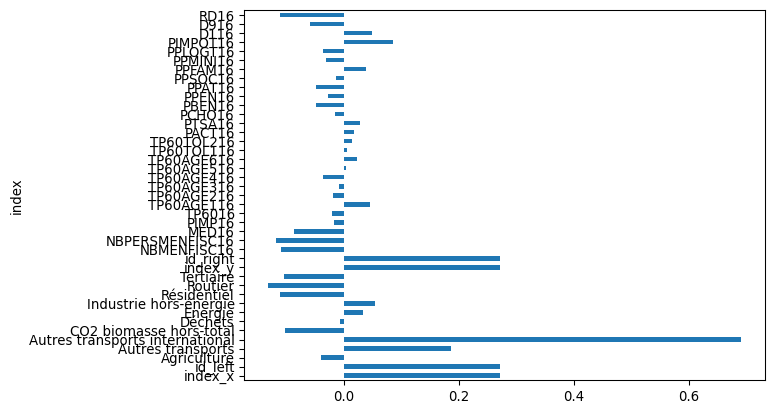

# 6. Formatter des tableaux de statistiques descriptives

Un *dataframe* `Pandas`
est automatiquement mis en forme lorsqu’il est visualisé depuis un *notebook* sous forme de table HTML à la mise en forme minimaliste.
Cette mise en forme est pratique pour voir
les données, une tâche indispensable pour les *data scientists*
mais ne permet pas d’aller vraiment au-delà.

Dans une phase
exploratoire, il peut être pratique d’avoir un tableau
un peu plus complet, intégrant notamment des visualisations
minimalistes, pour mieux connaître ses données. Dans la phase
finale d’un projet, lorsqu’on communique sur un projet, il
est avantageux de disposer d’une visualisation attrative.
Pour ces deux besoins, les sorties des *notebooks* sont
une réponse peu satisfaisante, en plus de nécessiter
le *medium* du *notebook* qui peut en rebuter certains.

Heureusement, le tout jeune *package* [`great_tables`](https://posit-dev.github.io/great-tables/get-started/) permet, simplement, de manière programmatique, la création de tableaux
qui n’ont rien à envier à des productions manuelles fastidieuses faites dans `Excel`
et difficilement répliquables. Ce *package* est un portage en `Python` du *package* [`GT`](https://gt.rstudio.com/).
`great_tables` construit des tableaux
*html* ce qui offre une grande richesse dans la mise en forme et permet une excellente intégration avec [`Quarto`](https://quarto.org/), l’outil de publication reproductible développé par
L’exercice suivant proposera de construire un tableau avec
ce *package*, pas à pas.

Afin de se concentrer sur la construction du tableau,
les préparations de données à faire en amont sont données
directement. Nous allons repartir de ce jeu de données:

In [66]:
emissions_merged.head(3)


3 rows × 49 columns

Nous allons construire un tableau de statistiques
descriptives par département mettant en parallèle
l’empreinte carbone, le revenu médian et la population
de chaque département

In [67]:
emissions_table = (
    emissions_merged.rename(
        columns={"dep_y": "dep", "NBPERSMENFISC16": "population", "MED16": "revenu"}
    )
    .groupby("dep")
    .agg(
        {"empreinte": "sum", "revenu": "median", "population": "sum"}
    )  # pas vraiment le revenu médian
    .reset_index()
    .sort_values(by="empreinte")
)


Dans ce tableau nous allons intégrer des barres horizontales,
à la manière des exemples présentés [ici](https://posit-dev.github.io/great-tables/examples/). Cela se fait en incluant directement
le code *html* dans la colonne du *DataFrame*

In [68]:
def create_bar(
    prop_fill: float, max_width: int, height: int, color: str = "green"
) -> str:
    """Create divs to represent prop_fill as a bar."""
    width = round(max_width * prop_fill, 2)
    px_width = f"{width}px"
    return f"""\
    <div style="width: {max_width}px; background-color: lightgrey;">\
        <div style="height:{height}px;width:{px_width};background-color:{color};"></div>\
    </div>\
    """


colors = {"empreinte": "green", "revenu": "red", "population": "blue"}

for variable in ["empreinte", "revenu", "population"]:
    emissions_table[f"raw_perc_{variable}"] = (
        emissions_table[variable] / emissions_table[variable].max()
    )
    emissions_table[f"bar_{variable}"] = emissions_table[f"raw_perc_{variable}"].map(
        lambda x: create_bar(x, max_width=75, height=20, color=colors[variable])
    )


Nous ne gardons que les 5 plus petites empreintes carbone, et les
cinq plus importantes.

In [69]:
emissions_min = (
    emissions_table.head(5)
    .assign(grp="5 départements les moins pollueurs")
    .reset_index(drop=True)
)
emissions_max = (
    emissions_table.tail(5)
    .assign(grp="5 départements les plus pollueurs")
    .reset_index(drop=True)
)

emissions_table = pd.concat([emissions_min, emissions_max])


Enfin, pour pouvoir utiliser quelques fonctions
pratiques pour sélectionner des colonnes à partir
de motifs, nous allons convertir les données
au format [`Polars`](https://pola.rs/)

In [70]:
import polars as pl

emissions_table = pl.from_pandas(emissions_table)


<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 5: Un beau tableau de statistiques descriptives (exercice libre)</h3>

En prenant comme base ce tableau

``` python
GT(emissions_table, groupname_col="grp", rowname_col="dep")
```

construire un tableau dans le style de celui ci-dessous

</div>

Le tableau à obtenir:

Grâce à celui-ci, on peut déjà comprendre que notre définition
de l’empreinte carbone est certainement défaillante. Il apparaît
peu plausible que les habitants du 77 aient une empreinte 500 fois
supérieure à celle de Paris intra-muros. La raison principale ?
On n’est pas sur un concept d’émissions à la consommation mais à la
production, ce qui pénalise les espaces industriels ou les espaces
avec des aéroports…

Pour aller plus loin sur la construction de tableaux
avec `great_tables`, vous pouvez répliquer
cet [exercice](https://rgeo.linogaliana.fr/exercises/eval.html)
de production de tableaux électoraux
que j’ai proposé pour un cours de `R` avec `gt`, l’équivalent
de `great_tables` pour `R`.

# 7. `Pandas`: vers la pratique et au-delà

## 7.1 `Pandas` dans une chaine d’opérations

En général, dans un projet, le nettoyage de données va consister en un ensemble de
méthodes appliquées à un `DataFrame` ou alors une `Serie` lorsqu’on travaille exclusivement sur une colonne.
Autrement dit, ce qui est généralement attendu lorsqu’on fait du `Pandas` c’est d’avoir une chaîne qui prend un `DataFrame` en entrée et ressort ce même `DataFrame` enrichi, ou une version agrégée de celui-ci, en sortie.

Cette manière de procéder est le coeur de la syntaxe `dplyr` en `R` mais n’est pas forcément native en `Pandas` selon les opérations qu’on désire mettre en oeuvre. En effet, la manière naturelle de mettre à jour un *dataframe* en `Pandas` passe souvent par une syntaxe du type:

In [72]:
import numpy as np
import pandas as pd

data = [[8000, 1000], [9500, np.nan], [5000, 2000]]
df = pd.DataFrame(data, columns=["salaire", "autre_info"])
df["salaire_net"] = df["salaire"] * 0.8


En `SQL` on pourrait directement mettre à jour notre base de données avec la nouvelle colonne :

``` sql
SELECT *, salaire*0.8 AS salaire_net FROM df
```

L’écosystème du *tidyverse* en `R`, l’équivalent de `Pandas`, fonctionne selon la même logique que SQL de mise à jour de table. On ferait en effet la commande suivante avec `dplyr`:

``` r
df %>% mutate(salaire_net = salaire*0.8) 
```

Techniquement on pourrait faire ceci avec un `assign` en `Pandas`

In [73]:
df = df.drop("salaire_net", axis="columns")
df = df.assign(salaire_net=lambda s: s["salaire"] * 0.8)

Cependant cette syntaxe `assign` n’est pas très naturelle. Il est nécessaire de lui passer une *lambda function* qui attend comme *input* un `DataFrame` là où on voudrait une colonne. Il ne s’agit donc pas vraiment d’une syntaxe lisible et pratique.

Il est néanmoins possible d’enchaîner des opérations sur des jeux de données grâce aux [*pipes*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pipe.html). Ceux-ci reprennent la même philosophie que celle de `dplyr`, elle-même inspirée du *pipe* Linux.
Cette approche permettra de rendre plus lisible le code en définissant des fonctions effectuant des opérations sur une ou plusieurs colonnes d’un DataFrame. Le premier argument à indiquer à la fonction est le `DataFrame`, les autres sont ceux permettant de contrôler son comportement

In [74]:
def calcul_salaire_net(df: pd.DataFrame, col: str, taux: float = 0.8):
    df["salaire_net"] = df[col] * taux
    return df


Ce qui transforme notre chaine de production en

In [75]:
(df.pipe(calcul_salaire_net, "salaire"))


## 7.2 Quelques limites sur la syntaxe de `Pandas`

Il y a un avant et un après `Pandas` dans l’analyse de données en `Python`. Sans ce *package* ô combien pratique `Python`, malgré toutes les forces de ce langage, aurait eu du mal à s’installer dans le paysage de l’analyse de données. Cependant, si `Pandas` propose une syntaxe cohérente sur de nombreux aspects, elle n’est pas parfaite non plus. Les paradigmes plus récents d’analyse de données en `Python` ont d’ailleurs parfois l’ambition de corriger ces imperfections syntaxiques là.

Parmi les points les plus génants au quoditien il y a le besoin de régulièrement faire des `reset_index` lorsqu’on construit des statistiques descriptives. En effet, il peut être dangereux de garder des indices qu’on ne contrôle pas bien car, sans attention de notre part lors des phases de *merge*, ils peuvent être utilisés à mauvais escient par `Pandas` pour joindre les données ce qui peut provoquer des suprises.

`Pandas` est extrêmement bien fait pour restructurer des données du format *long* to *wide* ou *wide* to *long*. Cependant, ce n’est pas la seule manière de restructurer un jeu de données qu’on peut vouloir mettre en oeuvre. Il arrive régulièrement qu’on désire comparer la valeur d’une observation à celle d’un groupe à laquelle elle appartient. C’est notamment particulièrement utile dans une phase d’analyse des anomalies, valeurs aberrantes ou lors d’une investigation de détection de fraude. De manière native, en `Pandas`, il faut construire une statistique agrégée par groupe et refaire un *merge* aux données initiales par le biais de la variable de groupe. C’est un petit peu fastidieux:

In [76]:
emissions_moyennes = emissions.groupby("dep").agg({"Agriculture": "mean"}).reset_index()
emissions_enrichies = emissions.merge(
    emissions_moyennes, on="dep", suffixes=["", "_moyenne_dep"]
)
emissions_enrichies["relatives"] = (
    emissions_enrichies["Agriculture"] / emissions_enrichies["Agriculture_moyenne_dep"]
)
emissions_enrichies.head()


Dans le *tidyverse*, cette opération en deux temps pourrait être faite en une seule étape, ce qui est plus pratique

``` r
emissions %>%
  group_by(dep) %>%
  mutate(relatives = Agriculture/mean(Agriculture))
```

Ce n’est pas si grave mais cela alourdit la longueur des chaines de traitement faites en `Pandas` et donc la charge de maintenance pour les faire durer dans le temps.

De manière plus générale, les chaînes de traitement `Pandas` peuvent être assez verbeuses, car il faut régulièrement redéfinir le `DataFrame` qu’on utilise plutôt que simplement les colonnes. Par exemple, pour faire un filtre sur les lignes et les colonnes, il faudra faire:

In [77]:
(
    emissions.loc[
        (emissions["dep"] == "12") & (emissions["Routier"] > 500),
        ["INSEE commune", "Commune"],
    ].head(5)
)


En SQL on pourrait se contenter de faire référence aux colonnes dans le filter

``` sql
SELECT "INSEE commune", 'Commune'
FROM emissions 
WHERE dep=="12" AND Routier>500
```

Dans le *tidyverse* (`R`) on pourrait aussi faire ceci simplement

``` r
df %>%
  filter(dep=="12", Routier>500) %>%
  select(`INSEE commune`, `Commune`)
```

# 8. Les autres paradigmes

Ces deux chapitres ont permis d’explorer en profondeur la richesse de l’écosystème `Pandas` qui est un indispensable dans la boite à outil du *data scientist*. Malgré toutes les limites que nous avons pu évoquer, et les solutions alternatives que nous allons présenter, `Pandas` reste LE *package* central de l’écosystème de la donnée avec `Python`. Nous allons voir dans les prochains chapitres son intégration native à l’écosystème `Scikit` pour le *machine learning* ou l’extension de `Pandas` aux données spatiales avec `GeoPandas`.

Les autres solutions techniques que nous allons ici évoquer peuvent être pertinentes si on désire traiter des volumes de données importants ou si on désire utiliser des syntaxes alternatives.

Les principales alternatives à `Pandas` sont [`Polars`](https://pola.rs/), [`DuckDB`](https://duckdb.org/) et [`Spark`](https://spark.apache.org/docs/latest/api/python/index.html). Il existe également [`Dask`](https://www.dask.org/), une librairie pour paralléliser des traitements écris en `Pandas`.

## 8.1 `Polars`

`Polars` est certainement le paradigme le plus inspiré de `Pandas`, jusqu’au choix du nom. La première différence fondamentale est dans les couches internes utilisées. `Polars` s’appuie sur l’implémentation `Rust` de `Arrow` là où `Pandas` s’appuie sur `Numpy` ce qui est facteur de perte de performance. Cela permet à `Polars` d’être plus efficace sur de gros volumes de données, d’autant que de nombreuses opérations sont parallélisées et reposent sur l’évaluation différées (*lazy evaluation*) un principe de programmation qui permet d’optimiser les requêtes pour ne pas les exécuter dans l’ordre de définition mais dans un ordre logique plus optimal.

Une autre force de `Polars` est la syntaxe plus cohérente, qui bénéficie du recul d’une quinzaine d’années d’existence de `Pandas` et d’une petite dizaine d’années de `dplyr` (le *package* de manipulation de données au sein du paradigme du *tidyverse* en `R`). Pour reprendre l’exemple précédent, il n’est plus nécessaire de forcer la référence au *DataFrame*, dans une chaîne d’exécution toutes les références ultérieures seront faites au regard du *DataFrame* de départ

In [79]:
import polars as pl

emissions_polars = pl.from_pandas(emissions)
(
    emissions_polars.filter(pl.col("dep") == "12", pl.col("Routier") > 500)
    .select("INSEE commune", "Commune")
    .head(5)
)


Pour découvrir `Polars`, de nombreuses ressources en ligne sont accessibles, notamment [ce *notebook*](https://github.com/InseeFrLab/ssphub/blob/main/post/polars/polars-tuto.ipynb) construit pour le réseau des *data scientists* de la statistique publique.

## 8.2 `DuckDB`

*DuckDB* est le nouveau venu dans l’écosystème de l’analyse de données repoussant les limites des données pouvant être traitées avec `Python` sans passer par des outils *big data* comme `Spark`.
*DuckDB* est la quintessence d’un nouveau paradigme, celui du [*“Big data is dead”*](https://motherduck.com/blog/big-data-is-dead/), où on peut traiter des données de volumétrie importante sans recourir à des infrastructures imposantes.

Outre sa grande efficacité, puisqu’avec *DuckDB* on peut traiter des données d’une volumétrie supérieure à la mémoire vive de l’ordinateur ou du serveur, *DuckDB* présente l’avantage de proposer une syntaxe uniforme quelle que soit le langage qui appelle *DuckDB* (`Python`, `R`, `C++` ou `Javascript`). *DuckDB* privilégie la syntaxe SQL pour traiter les données avec de nombreuses fonctions pré-implementées pour simplifier certaines transformations de données (par exemple pour les [données textuelles](https://duckdb.org/docs/sql/functions/char.html), les [données temporelles](https://duckdb.org/docs/sql/functions/time), etc.).

Par rapport à d’autres systèmes s’appuyant sur SQL, comme [`PostGreSQL`](https://www.bing.com/search?go=Rechercher&q=PostGreSQL&qs=ds&form=QBRE), `DuckDB` est très simple d’installation, ce n’est qu’une librairie `Python` là où beaucoup d’outils comme `PostGreSQL` nécessite une infrastructure adaptée.

Pour reprendre l’exemple précédent, on peut utiliser directement le code SQL précédent

In [81]:
import duckdb

duckdb.sql(
    """
  SELECT "INSEE commune", "Commune"
  FROM emissions
  WHERE dep=='12' AND Routier>500
  LIMIT 5
  """
)


┌───────────────┬─────────────────────┐
│ INSEE commune │       Commune       │
│    varchar    │       varchar       │
├───────────────┼─────────────────────┤
│ 12001         │ AGEN-D'AVEYRON      │
│ 12002         │ AGUESSAC            │
│ 12006         │ ALRANCE             │
│ 12007         │ AMBEYRAC            │
│ 12008         │ ANGLARS-SAINT-FELIX │
└───────────────┴─────────────────────┘

Ici la clause `FROM emissions` vient du fait qu’on peut directement exécuter du SQL depuis un objet `Pandas` par le biais de `DuckDB`. Si on fait la lecture directement dans la requête, celle-ci se complexifie un petit peu mais la logique est la même

In [82]:
import duckdb

duckdb.sql(
    f"""
  SELECT "INSEE commune", "Commune"
  FROM read_csv_auto("{url}")
  WHERE
    substring("INSEE commune",1,2)=='12'
    AND
    Routier>500
  LIMIT 5
  """
)


┌───────────────┬─────────────────────┐
│ INSEE commune │       Commune       │
│    varchar    │       varchar       │
├───────────────┼─────────────────────┤
│ 12001         │ AGEN-D'AVEYRON      │
│ 12002         │ AGUESSAC            │
│ 12006         │ ALRANCE             │
│ 12007         │ AMBEYRAC            │
│ 12008         │ ANGLARS-SAINT-FELIX │
└───────────────┴─────────────────────┘

Le rendu du *DataFrame* est légèrement différent de `Pandas` car, comme `Polars` et de nombreux systèmes de traitement de données volumineuses, `DuckDB` repose sur l’évaluation différée et donc ne présente en *display* qu’un échantillon de données.
`DuckDB` et `Polars` sont d’ailleurs très bien intégrés l’un à l’autre. On peut très bien faire du SQL sur un objet `Polars` via `DuckDB` ou appliquer des fonctions `Polars` sur un objet initialement lu avec `DuckDB`.

L’un des intérêts de `DuckDB` est son excellente intégration avec l’écosystème `Parquet`, le format de données déjà mentionné qui devient un standard dans le partage de données (il s’agit, par exemple, de la pierre angulaire du partage de données sur la plateforme *HuggingFace*). Pour en savoir plus sur `DuckDB` et découvrir son intérêt pour lire les données du recensement de la population française, vous pouvez consulter [ce post de blog](https://ssphub.netlify.app/post/parquetrp/).

## 8.3 `Spark` et le *big data*

`DuckDB` a repoussé les frontières du *big data* qu’on peut définir comme le volume de données à partir duquel on ne peut plus traiter celles-ci sur une machine sans mettre en oeuvre une stratégie de parallélisation.

Néanmoins, pour les données très volumineuses, `Python` est très bien armé grâce à la librairie [`PySpark`](https://spark.apache.org/docs/latest/api/python/index.html). Celle-ci est une API en Python pour le langage `Spark`, un langage *big data* basé sur Scala. Ce paradigme est construit sur l’idée que les utilisateurs de `Python` y accèdent par le biais de *cluster* avec de nombreux noeuds pour traiter la donnée de manière parallèle. Celle-ci sera lue par blocs, qui seront traités en parallèle en fonction du nombre de noeuds parallèles. L’API DataFrame de `Spark` présente une syntaxe proche de celle des paradigmes précédents avec une ingénieurie plus complexe en arrière-plan liée à la parallélisation native.